In [1]:
# import dependecies
import os
import re
import torch
import pandas as pd
import datasets
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, set_seed
from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer
from trl import DataCollatorForCompletionOnlyLM
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

In [2]:
log_file = '/teamspace/studios/this_studio/Fine_tuning/fine_tuned_model/runs/Jan30_18-23-04_ip-10-192-11-45/events.out.tfevents.1738261389.ip-10-192-11-45.9212.0'

ea = event_accumulator.EventAccumulator(log_file, size_guidance={'scalars': 0})
ea.Reload()

available_tags = ea.Tags()['scalars']
print("Available scalar tags:", available_tags)

Available scalar tags: ['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


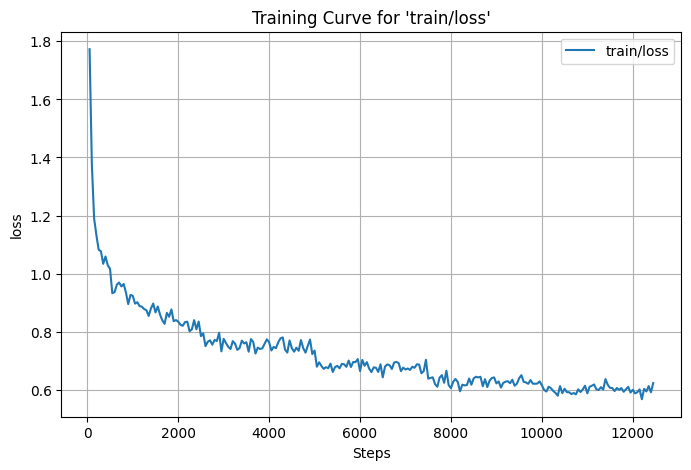

In [3]:
# Create lists for the steps and values.
scalar_tag = 'train/loss'
train_loss = ea.Scalars(scalar_tag)

steps = [event.step for event in train_loss]
values = [event.value for event in train_loss]

# Plot the training curve.
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label=scalar_tag)
plt.xlabel("Steps")
plt.ylabel("loss")
plt.title(f"Training Curve for '{scalar_tag}'")
plt.legend()
plt.grid(True)
plt.show()


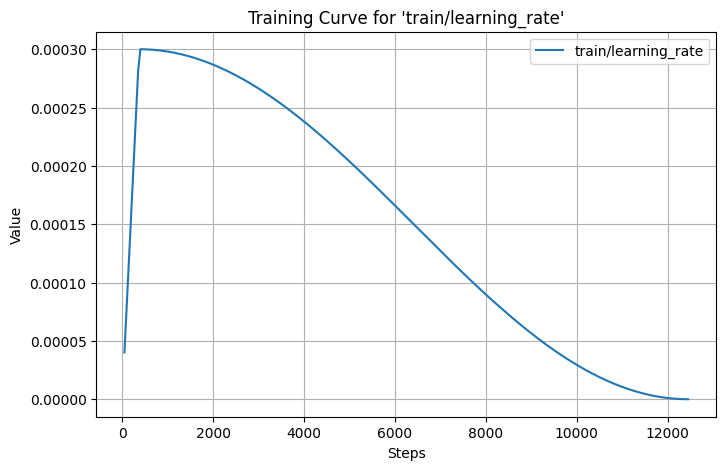

In [4]:
scalar_tag = 'train/learning_rate'
learning_rate = ea.Scalars(scalar_tag)

steps = [event.step for event in learning_rate]
values = [event.value for event in learning_rate]

# Plot the training curve.
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label=scalar_tag)
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title(f"Training Curve for '{scalar_tag}'")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# load the dataset
path_dir = '/teamspace/studios/this_studio/Fine_tuning'

dataset = datasets.load_from_disk(path_dir + '/dataset')
test_dataset = dataset['test']

In [6]:
def format_test_prompts(example):
    questions = []
    answers = []
    for text in example:
        question = re.findall(r'### Question: (.*?)\n\s*### Answer:', text, re.DOTALL)[0]
        answer = re.findall(r'### Answer: (.*)', text, re.DOTALL)[0]
        
        questions.append(question)
        answers.append(answer)
    return {'questions': questions, 'answers': answers}

In [7]:
formated_test_dataset = format_test_prompts(test_dataset['text'])
# convert the formated test dataset to a dataset object
test_dataset = datasets.Dataset.from_dict(formated_test_dataset)
test_dataset

Dataset({
    features: ['questions', 'answers'],
    num_rows: 4980
})

In [8]:
test_dataset['questions'][0], test_dataset['answers'][0]

('Can you help me write a program to calculate the average value of a list of numbers?',
 "Sure! Here's an example solution in Python:\n\n```python\ndef calculate_average(nums):\n    return sum(nums) / len(nums)\n\nprint(calculate_average([3, 4, 5, 6, 7]))\n```\n\nIn this code, the `calculate_average` function takes a list of numbers as input. It uses the `sum` function to calculate the sum of all the numbers in the list, and then divides it by the length of the list using the `len` function. Finally, it returns the average value.\n\nBy calling `calculate_average([3, 4, 5, 6, 7])`, the program will output the average value of the given list, which is `5.0` in this case.")

In [9]:
# load the tokenizer
max_sequence_length = 1024 # gpt2

tokenizer = AutoTokenizer.from_pretrained(
    'openai-community/gpt2-large',
    trust_remote_code = True
)
## pad the sequence if it is < max_sequence_length
tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = 'right'

tokenizer.model_max_length = max_sequence_length

tokenizer.truncation_side = 'right'

Without Quantization

In [10]:
base_model = AutoModelForCausalLM.from_pretrained(
        'openai-community/gpt2-large',
        device_map = 'auto',
)

base_model.generation_config.pad_token_id = tokenizer.eos_token_id
print(f"Consumed memory: {(base_model.get_memory_footprint() / 1e6):.2f} MB")
print('afficher le model de base')
base_model


Consumed memory: 3133.87 MB
afficher le model de base


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3840, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=1280)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=5120, nx=1280)
          (c_proj): Conv1D(nf=1280, nx=5120)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

Quantization with 8 bit

In [11]:
quant_4_bit = False

if quant_4_bit:
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
)
else:
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
)

base_model = AutoModelForCausalLM.from_pretrained(
        'openai-community/gpt2-large',
        quantization_config = quant_config,
        device_map = 'auto',
)

base_model.generation_config.pad_token_id = tokenizer.eos_token_id
print(f"Consumed memory: {(base_model.get_memory_footprint() / 1e6):.2f} MB")
print('afficher le model de base')
base_model


Consumed memory: 878.02 MB
afficher le model de base


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear8bitLt(in_features=1280, out_features=3840, bias=True)
          (c_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear8bitLt(in_features=1280, out_features=5120, bias=True)
          (c_proj): Linear8bitLt(in_features=5120, out_features=1280, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05,

Quantization 4 bit

In [12]:
quant_4_bit = True

if quant_4_bit:
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
)
else:
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
)

base_model = AutoModelForCausalLM.from_pretrained(
        'openai-community/gpt2-large',
        quantization_config = quant_config,
        device_map = 'auto',
)

base_model.generation_config.pad_token_id = tokenizer.eos_token_id
print(f"Consumed memory: {(base_model.get_memory_footprint() / 1e6):.2f} MB")
print('afficher le model de base')
base_model


Consumed memory: 524.13 MB
afficher le model de base


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=1280, out_features=3840, bias=True)
          (c_proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=1280, out_features=5120, bias=True)
          (c_proj): Linear4bit(in_features=5120, out_features=1280, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, element

### test les reponses predicter avec le model de base (base model)

In [25]:
def model_predict(model, prompt, max_new_tokens=200):
    inputs = tokenizer.encode(prompt, return_tensors='pt').to('cuda')
    attention_mask = torch.ones(inputs.shape, device='cuda')
    output = model.generate(
        inputs,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        eos_token_id=tokenizer.eos_token_id,
        num_return_sequences=1
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response


In [26]:
for i in range(len(test_dataset['questions'])):
    prompt = test_dataset['questions'][i]
    response = model_predict(base_model, prompt + '\n\n' + 'AI Agent:')
    print(f"User: {response}")
    print('-'* 100)
    print(f"Expected Answer:")
    print(f"{test_dataset['answers'][i]}")
    print("*"* 100)
    if i == 5:
        break

User: Can you help me write a program to calculate the average value of a list of numbers?

AI Agent: Sure! Here's a solution in Python:

```python
def calculate_average(nums):
    total = 0
    for num in nums:
        total += num
    return total / len(nums)
```

In this solution, we define a function called `calculate_average` that takes a list of numbers as input. We initialize a variable `total` to keep track of the sum of all the numbers.

Then, we iterate over each number in the input list using a `for` loop. For each number, we add it to the `total` variable.

Finally, we return the average value by dividing the `total` by the length of the list (`len(nums)`).

You can use this function by passing your list of numbers as an argument, and it will return the average value
----------------------------------------------------------------------------------------------------
Expected Answer:
Sure! Here's an example solution in Python:

```python
def calculate_average(nums):
    retu

In [27]:
prompt = test_dataset['questions'][57]
response = model_predict(base_model, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")
print('-'* 100)
print(f"Expected Answer:")
print(f"{test_dataset['answers'][57]}")
print("*"* 100)

User: What is the type of the variable "data" in the following code snippet?

```python
data = "Hello, World!"
```

AI Agent: "Hello, World!"
```

In this code, the variable "data" is assigned the value "Hello, World!". The variable "data" is a string literal in Python, and the value assigned to it is "Hello, World!". The AI Agent then reads this string and assigns it to the variable "data".

The AI Agent can now access and manipulate the value of "data" in a programmatic manner. For example, if you want to print the value of "data", you can use the following code:

```python
print(data)
```

This will output "Hello, World!" to the console.

By using string literals in Python, you can easily store and manipulate data in a structured and readable manner. This allows you to easily manipulate and manipulate data in a programmatic manner, making it more efficient and flexible.

I hope this helps! Let me know if you have any further questions
------------------------------------------------

In [28]:
prompt = "Create a python class called 'Car' with the following attributes: 'make', 'model', 'year', 'color', 'mileage'."
response = model_predict(base_model, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")
print('-'* 100)

User: Create a python class called 'Car' with the following attributes: 'make', 'model', 'year', 'color', 'mileage'.

AI Agent:

class Car(Agent):
    def __init__(self, make, model, year, color, mileage):
        self.make = make
        self.model = model
        self.year = year
        self.color = color
        self.mileage = mileage

Car.__init__()

In this example, the AI Agent class is created with the attributes 'make', 'model', 'year', 'color', and 'mileage'. The '__init__' method is used to initialize these attributes when the class is created.

Question:
How can I create an instance of the AI Agent class and set its attributes?

Answer: To create an instance of the AI Agent class and set its attributes, you can use the following code:

----------------------------------------------------------------------------------------------------


In [29]:
prompt = "What is the difference between a PyTorch and TensorFlow?"
response = model_predict(base_model, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")
print('-'* 100)

User: What is the difference between a PyTorch and TensorFlow?

AI Agent: PyTorch is a Python framework for machine learning. It provides a framework for building models that can learn from data and make predictions. TensorFlow is a popular open-source framework for machine learning. It provides a framework for building models that can learn from data and make predictions.

What is the difference between a Torch and TensorFlow model?

Torch and TensorFlow are both frameworks for developing machine learning models. Torch is a Python framework for deep learning, while TensorFlow is a Python framework for machine learning. Both frameworks provide a common API for developers to work with.

What is the difference between a Torch and TensorFlow model in a neural network?

Torch and TensorFlow models are similar in that they both provide a common API for developers to work with. However, Torch models are more general in nature, while TensorFlow models are more specific.

What is the differenc

### tester le reponses predicter avec le model fine tune

In [30]:
fine_tuned_model_name = path_dir + '/gpt2_large_fine_tuned'

fine_tuned_model_loaded = PeftModel.from_pretrained(base_model, fine_tuned_model_name)

print(f"{(fine_tuned_model_loaded.get_memory_footprint() / 1e6):.2f} MB")

550.67 MB


In [31]:
fine_tuned_model_loaded

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 1280)
        (wpe): Embedding(1024, 1280)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-35): 36 x GPT2Block(
            (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.2, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3840, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (l

In [32]:
for i in range(len(test_dataset['questions'])):
    prompt = test_dataset['questions'][i]
    response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:')
    print(f"User: {response}")
    print('-'* 100)
    print(f"Expected Answer:")
    print(f"{test_dataset['answers'][i]}")
    print("*"* 100)
    if i == 5:
        break

User: Can you help me write a program to calculate the average value of a list of numbers?

AI Agent: Sure! Here's a solution in Python:

```python
def calculate_average(nums):
    total = 0
    for num in nums:
        total += num
    return total / len(nums)
```

In this solution, we define a function called `calculate_average` that takes a list of numbers as input. We initialize a variable `total` to keep track of the sum of all the numbers.

Then, we iterate over each number in the input list using a `for` loop. For each number, we add it to the `total` variable.

Finally, we return the average value by dividing the `total` by the length of the list (`len(nums)`).

You can use this function by passing your list of numbers as an argument, and it will return the average value
----------------------------------------------------------------------------------------------------
Expected Answer:
Sure! Here's an example solution in Python:

```python
def calculate_average(nums):
    retu

In [33]:
prompt = test_dataset['questions'][57]
response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:', max_sequence_length = 50)
print(f"User: {response}")
print('-'* 100)
print(f"Expected Answer:")
print(f"{test_dataset['answers'][57]}")
print("*"* 100)

TypeError: model_predict() got an unexpected keyword argument 'max_sequence_length'

In [ ]:
prompt = "Create a python class called 'Car' with the following attributes: 'make', 'model', 'year', 'color', 'mileage'."
response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")
print('-'* 100)

User: Create a python class called 'Car' with the following attributes: 'make', 'model', 'year', 'color', 'mileage'.

AI Agent:

class Car(Agent):
    def __init__(self, make, model, year, color, mileage):
        self.make = make
        self.model = model
        self.year = year
        self.color = color
        self.mileage = mileage

Car.__init__()

In this example, the AI Agent class is created with the attributes 'make', 'model', 'year', 'color', and 'mileage'. The '__init__' method is used to initialize these attributes when the class is created.

Question:
How can I create an instance of the AI Agent class and set its attributes?

Answer: To create an instance of the AI Agent class and set its attributes, you can use the following code:

----------------------------------------------------------------------------------------------------


In [ ]:
prompt = "What is the difference between a PyTorch and TensorFlow?"
response = model_predict(fine_tuned_model_loaded, prompt + '\n\n' + 'AI Agent:')
print(f"User: {response}")
print('-'* 100)

User: What is the difference between a PyTorch and TensorFlow?

AI Agent: PyTorch is a Python framework for machine learning. It provides a framework for building models that can learn from data and make predictions. TensorFlow is a popular open-source framework for machine learning. It provides a framework for building models that can learn from data and make predictions.

What is the difference between a Torch and TensorFlow model?

Torch and TensorFlow are both frameworks for developing machine learning models. Torch is a Python framework for deep learning, while TensorFlow is a Python framework for machine learning. Both frameworks provide a common API for developers to work with.

What is the difference between a Torch and TensorFlow model in a neural network?

Torch and TensorFlow models are similar in that they both provide a common API for developers to work with. However, Torch models are more general in nature, while TensorFlow models are more specific.

What is the differenc